In [1]:
import pandas as pd
import numpy as np
np.random.seed(123)  # for reproducibility
 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf

from scipy.ndimage import rotate

from matplotlib import pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

[]

In [3]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [4]:
# read in data
training = pd.read_csv("all/training.csv")
training.shape

(7049, 31)

In [5]:
training.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

# Data Validation 
## Check missing distributions

In [4]:
# check missing distribution
check1 = pd.isnull(training)
check2 = check1.groupby(list(check1.columns[:-1]))['Image'].value_counts().to_dict()

In [5]:
check3 = list(check1.groupby(list(check1.columns[:-1]))['Image'].count())
for i in range(len(check3)):
    print(i, ":", check3[i])

0 : 2140
1 : 13
2 : 3
3 : 4
4 : 3
5 : 1
6 : 3
7 : 26
8 : 1
9 : 1
10 : 2
11 : 31
12 : 1
13 : 2
14 : 6
15 : 1
16 : 2
17 : 1
18 : 3
19 : 1
20 : 1
21 : 2
22 : 1
23 : 1
24 : 1
25 : 4
26 : 2
27 : 1
28 : 1
29 : 1
30 : 2
31 : 1
32 : 3
33 : 2
34 : 4755
35 : 10
36 : 1
37 : 3
38 : 1
39 : 1
40 : 1
41 : 1
42 : 1
43 : 1
44 : 1
45 : 1
46 : 1
47 : 1
48 : 1
49 : 1


In [6]:
case = 6
for i in range(len(list(check2.items())[case][0])):
    print(i, list(check2.items())[case][0][i], ":", list(check1.columns)[i])

0 False : left_eye_center_x
1 False : left_eye_center_y
2 False : right_eye_center_x
3 False : right_eye_center_y
4 False : left_eye_inner_corner_x
5 False : left_eye_inner_corner_y
6 False : left_eye_outer_corner_x
7 False : left_eye_outer_corner_y
8 False : right_eye_inner_corner_x
9 False : right_eye_inner_corner_y
10 False : right_eye_outer_corner_x
11 False : right_eye_outer_corner_y
12 False : left_eyebrow_inner_end_x
13 False : left_eyebrow_inner_end_y
14 False : left_eyebrow_outer_end_x
15 False : left_eyebrow_outer_end_y
16 False : right_eyebrow_inner_end_x
17 False : right_eyebrow_inner_end_y
18 False : right_eyebrow_outer_end_x
19 False : right_eyebrow_outer_end_y
20 False : nose_tip_x
21 False : nose_tip_y
22 True : mouth_left_corner_x
23 True : mouth_left_corner_y
24 True : mouth_right_corner_x
25 True : mouth_right_corner_y
26 True : mouth_center_top_lip_x
27 True : mouth_center_top_lip_y
28 True : mouth_center_bottom_lip_x
29 True : mouth_center_bottom_lip_y
30 False : I

## Data Validation Findings

**2140 obs are non-missing (case 0)**

**4755 obs only have 8 non-missing key points (case 34)**
* False : left_eye_center_x
* False : left_eye_center_y
* False : right_eye_center_x
* False : right_eye_center_y
* False : nose_tip_x
* False : nose_tip_y
* False : mouth_center_bottom_lip_x
* False : mouth_center_bottom_lip_y
    
**31 obs only missing left_eyebrow_outer_end (case 11)**
* True : left_eyebrow_outer_end_x
* True : left_eyebrow_outer_end_y

**26 obs only missing right_eyebrow_outer_end (case 7)**
* True : right_eyebrow_outer_end_x
* True : right_eyebrow_outer_end_y

**13 obs only missing mouth_center_bottom_lip (case 1)**
* True : mouth_center_bottom_lip_x
* True : mouth_center_bottom_lip_y

**10 obs only have the following non-missing key points (case 35)**
* False : left_eye_center_x
* False : left_eye_center_y
* False : right_eye_center_x
* False : right_eye_center_y
* False : nose_tip_x
* False : nose_tip_y

**74 remaining obs have various missing points**

## Data Validation Decisions

Build two models, each to predict the following key points:

**Model 1:**
number of non-missing observations: 7000
* left_eye_center
* right_eye_center
* nose_tip
* mouth_center_bottom_lip

**Model 2:**
number of non-missing observations: 2155
* left_eye_inner_corner
* left_eye_outer_corner
* right_eye_inner_corner
* right_eye_outer_corner

* left_eyebrow_inner_end
* left_eyebrow_outer_end
* right_eyebrow_inner_end
* right_eyebrow_outer_end

* mouth_left_corner
* mouth_right_corner
* mouth_center_top_lip

In [10]:
# how many data points would we have?
points = [0, 1, 2, 3, 20, 21, 28, 29]
model = training.iloc[:, points]
print(model.shape)
model_nonmiss = model[~np.isnan(model).any(axis=1)]
print(model_nonmiss.shape)

(7049, 8)
(7000, 8)


In [11]:
points = list(range(4,20)) + list(range(22,28))
model = training.iloc[:, points]
print(model.shape)
model_nonmiss = model[~np.isnan(model).any(axis=1)]
print(model_nonmiss.shape)

(7049, 22)
(2155, 22)


# Data Preprocessing
## Split training and validation

In [5]:
# shuffle dataset
np.random.seed(666)
shuffle = np.random.permutation(np.arange(training.shape[0]))
training2 = training.iloc[shuffle].reset_index(drop=True)

# split out image values
image = []
for i in range(training2.shape[0]):
    img = training2['Image'][i].split(' ')
    img = ['0' if j == '' else j for j in img]
    image.append(img)

In [6]:
# create training and validation set (80/20 split)
X = np.array(image, dtype = 'float')
X_train, X_val = X[:5640], X[5640:]
print(X_train.shape, X_val.shape)

# create training and validation labels (80/20 split)
labels = training2.drop('Image', axis=1)
y = np.array(labels, dtype = 'float')
y_train, y_val = y[:5640], y[5640:]
print(y_train.shape, y_val.shape)

(5640, 9216) (1409, 9216)
(5640, 30) (1409, 30)


## Apply transformations

### 1. Mirroring

In [22]:
# define mirror functions
def mirror_X(input_X):
    return input_X.reshape(-1,96,96)[:, :, list(range(95, -1, -1))].reshape(-1, 96*96)
    
def mirror_y(input_y, n_point):
    output_y = input_y.copy()
    # y coordinate stays the same, x coordinate is 96-x
    output_y[:,list(range(0,n_point-1,2))] = 95 - input_y[:,list(range(0,n_point-1,2))]
    return output_y

In [23]:
# transform
X_train_mirror = mirror_X(X_train)
y_train_mirror = mirror_y(y_train, 30)
# X_val_mirror = mirror_X(X_val)
# y_val_mirror = mirror_y(y_val, 30)

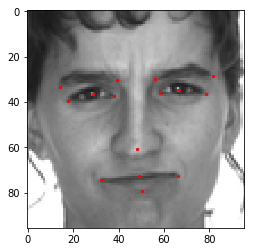

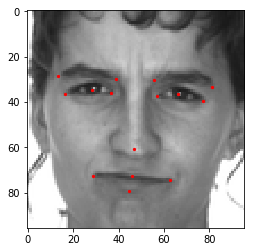

In [24]:
# check image
i=13
plt.imshow(X_train[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train[i, range(0, 30, 2)], y_train[i, range(1, 30, 2)], s=5, color='r')
plt.show()

plt.imshow(X_train_mirror[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train_mirror[i, range(0, 30, 2)], y_train_mirror[i, range(1, 30, 2)], s=5, color='r')
plt.show()

### 2. Rotating

In [25]:
# mirror function to transform X
def rotate_X(input_X, degree):
    
    # create an array of the same size
    output_X = np.zeros((input_X.shape), dtype=np.float64)
    
    # for each image, use sklearn's rotate function to rotate image
    # this somehow changes pixel values, cap value between 0 and 255
    for i in range(output_X.shape[0]):
        output_X[i] = np.clip(rotate(input_X.reshape(-1,96,96)[i], degree, reshape=False, mode='constant', \
                                       cval=150).reshape(96*96), 0, 255)  
    return output_X
        
    
# mirror function to transform y
def rotate_y(input_y, degree, n_point):
    
    # create an array of same size
    output_y = np.zeros((input_y.shape), dtype=np.float64)
    
    # define rotation angle and center of rotation
    theta = np.radians(degree)
    center_x = 95/2
    center_y = 95/2

    for i in range(output_y.shape[0]):
        
        # obtain x and y coordinates from dataset
        x = input_y[i][np.arange(0,n_point-1,2)]
        y = input_y[i][np.arange(1,n_point,2)]
        
        # use rotation matrix to rotate coordinates around center
        x2 = np.cos(theta) * (x - center_x) + np.sin(theta) * (y - center_y) + center_x
        y2 = -np.sin(theta) * (x - center_x) + np.cos(theta) * (y - center_y) + center_y
        
        # put x and y back in original shape
        output_y[i] = np.vstack((x2,y2)).transpose().flatten()
        
    return output_y

In [27]:
# transform
X_train_rotate = rotate_X(X_train, -15)
y_train_rotate = rotate_y(y_train, -15, 30)
# X_val_rotate = rotate_X(X_train, -15)
# y_val_rotate = rotate_y(y_train, -15)

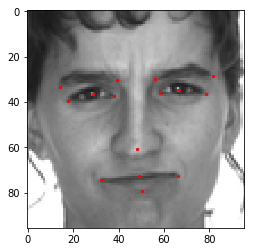

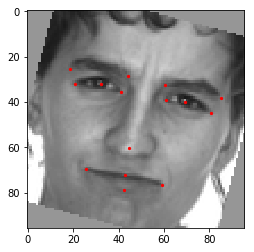

In [28]:
# check image
i=13

plt.imshow(X_train[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train[i, range(0, 30, 2)], y_train[i, range(1, 30, 2)], s=5, color='r')
plt.show()

plt.imshow(X_train_rotate[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train_rotate[i, range(0, 30, 2)], y_train_rotate[i, range(1, 30, 2)], s=5, color='r')
plt.show()

### 3. Contrast Reduction

In [30]:
# define function - only need to transform X
def reduce_contrast(input_X, weight):
    return (weight * input_X) + (1 - weight) * input_X.mean()

In [31]:
# transform
X_train_contrast = reduce_contrast(X_train, 0.7)
# X_val_contrast = reduce_contrast(X_val, 0.7)

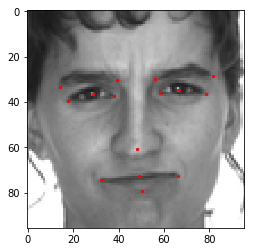

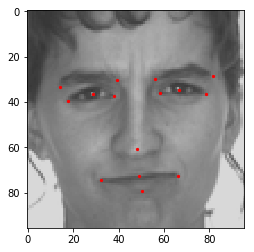

In [32]:
# check image
i=13

plt.imshow(X_train[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train[i, range(0, 30, 2)], y_train[i, range(1, 30, 2)], s=5, color='r')
plt.show()

plt.imshow(X_train_contrast[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train[i, range(0, 30, 2)], y_train[i, range(1, 30, 2)], s=5, color='r')
plt.show()

# Modeling

## Test data augmentation
### 0. Baseline

In [33]:
# test on model 1 with 8 points, prep data

# filter labels on only those 8 points
points = [0, 1, 2, 3, 20, 21, 28, 29]
y_train_model1 = y_train[:, points]
y_val_model1 = y_val[:, points]

# get index of non-missing labels
index_train = ~np.isnan(y_train_model1).any(axis=1)
index_val = ~np.isnan(y_val_model1).any(axis=1)

# filter out missing labels on training and validation data
X_train_nm = X_train[index_train]
y_train_nm = y_train_model1[index_train]
X_val_nm = X_val[index_val]
y_val_nm = y_val_model1[index_val]

print(X_train_nm.shape)
print(y_train_nm.shape)
print(X_val_nm.shape)
print(y_val_nm.shape)

(5603, 9216)
(5603, 8)
(1397, 9216)
(1397, 8)


In [18]:
# define simple CNN model with 3 conv layers and 2 fully connected layers
def SimpleModel_1(weights_path=None):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=(1,1), activation='relu', input_shape=(96,96,1), \
                     data_format='channels_last'))
    model.add(Conv2D(16, (3, 3), strides=(1,1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(8))

    if weights_path:
        model.load_weights(weights_path)

    return model

# define RMSE
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [20]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1 = model.fit(X_train_nm.reshape(-1,96,96,1), y_train_nm, \
                                        epochs=20, shuffle=True, batch_size=50, \
                                        validation_data=(X_val_nm.reshape(-1,96,96,1), y_val_nm), \
                                        verbose=2)

Train on 5603 samples, validate on 1397 samples
Epoch 1/50
 - 4s - loss: 19.4386 - rmse: 19.4386 - mean_absolute_error: 15.6785 - mean_absolute_percentage_error: 30.7632 - val_loss: 11.5144 - val_rmse: 11.5144 - val_mean_absolute_error: 8.9083 - val_mean_absolute_percentage_error: 18.2117
Epoch 2/50
 - 2s - loss: 11.8244 - rmse: 11.8244 - mean_absolute_error: 9.1873 - mean_absolute_percentage_error: 18.2008 - val_loss: 13.5408 - val_rmse: 13.5408 - val_mean_absolute_error: 10.8023 - val_mean_absolute_percentage_error: 21.3023
Epoch 3/50
 - 2s - loss: 11.4275 - rmse: 11.4275 - mean_absolute_error: 8.9408 - mean_absolute_percentage_error: 17.8049 - val_loss: 12.8248 - val_rmse: 12.8248 - val_mean_absolute_error: 10.0954 - val_mean_absolute_percentage_error: 20.7443
Epoch 4/50
 - 2s - loss: 11.1962 - rmse: 11.1962 - mean_absolute_error: 8.7720 - mean_absolute_percentage_error: 17.4290 - val_loss: 10.7316 - val_rmse: 10.7316 - val_mean_absolute_error: 8.4852 - val_mean_absolute_percentage_

Epoch 36/50
 - 2s - loss: 3.2717 - rmse: 3.2717 - mean_absolute_error: 2.5604 - mean_absolute_percentage_error: 5.2970 - val_loss: 5.6395 - val_rmse: 5.6395 - val_mean_absolute_error: 4.4047 - val_mean_absolute_percentage_error: 9.5660
Epoch 37/50
 - 2s - loss: 2.9781 - rmse: 2.9781 - mean_absolute_error: 2.3110 - mean_absolute_percentage_error: 4.8096 - val_loss: 5.6279 - val_rmse: 5.6279 - val_mean_absolute_error: 4.3725 - val_mean_absolute_percentage_error: 9.4101
Epoch 38/50
 - 2s - loss: 2.6365 - rmse: 2.6365 - mean_absolute_error: 2.0161 - mean_absolute_percentage_error: 4.2331 - val_loss: 5.8778 - val_rmse: 5.8778 - val_mean_absolute_error: 4.6104 - val_mean_absolute_percentage_error: 10.1669
Epoch 39/50
 - 2s - loss: 3.0828 - rmse: 3.0828 - mean_absolute_error: 2.4250 - mean_absolute_percentage_error: 5.0158 - val_loss: 6.1607 - val_rmse: 6.1607 - val_mean_absolute_error: 4.7863 - val_mean_absolute_percentage_error: 10.2845
Epoch 40/50
 - 2s - loss: 2.6029 - rmse: 2.6029 - mean

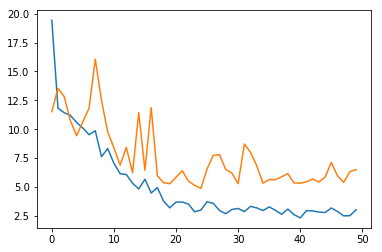

In [21]:
# plot metrics
print(min(history_SimpleModel_1.history['val_rmse']))
plt.plot(history_SimpleModel_1.history['rmse'])
plt.plot(history_SimpleModel_1.history['val_rmse'])
plt.show()

### 1. Test mirroring alone

In [35]:
# test on model 1 with 8 points, prep data
X_train_model = np.concatenate((X_train_nm, mirror_X(X_train_nm)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, mirror_y(y_train_nm, 8)), axis=0)
X_val_model = np.concatenate((X_val_nm, mirror_X(X_val_nm)), axis=0).reshape(-1,96,96,1)
y_val_model = np.concatenate((y_val_nm, mirror_y(y_val_nm, 8)), axis=0)

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(2794, 96, 96, 1)
(2794, 8)


In [33]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_mirror = model.fit(X_train_model, y_train_model, \
                                        epochs=20, shuffle=True, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

Train on 5603 samples, validate on 1397 samples
Epoch 1/50
 - 2s - loss: 18.7226 - rmse: 18.7226 - mean_absolute_error: 15.6389 - mean_absolute_percentage_error: 30.8342 - val_loss: 10.3040 - val_rmse: 10.3040 - val_mean_absolute_error: 7.8224 - val_mean_absolute_percentage_error: 15.7702
Epoch 2/50
 - 2s - loss: 10.8421 - rmse: 10.8421 - mean_absolute_error: 8.5256 - mean_absolute_percentage_error: 16.9306 - val_loss: 14.4478 - val_rmse: 14.4478 - val_mean_absolute_error: 11.0508 - val_mean_absolute_percentage_error: 22.1457
Epoch 3/50
 - 2s - loss: 9.2907 - rmse: 9.2907 - mean_absolute_error: 7.1595 - mean_absolute_percentage_error: 14.1738 - val_loss: 10.5202 - val_rmse: 10.5202 - val_mean_absolute_error: 8.1013 - val_mean_absolute_percentage_error: 16.7373
Epoch 4/50
 - 2s - loss: 8.4115 - rmse: 8.4115 - mean_absolute_error: 6.5789 - mean_absolute_percentage_error: 13.0983 - val_loss: 8.4601 - val_rmse: 8.4601 - val_mean_absolute_error: 6.4417 - val_mean_absolute_percentage_error: 

Epoch 36/50
 - 2s - loss: 2.0778 - rmse: 2.0778 - mean_absolute_error: 1.6086 - mean_absolute_percentage_error: 3.3397 - val_loss: 4.5962 - val_rmse: 4.5962 - val_mean_absolute_error: 3.2980 - val_mean_absolute_percentage_error: 7.2125
Epoch 37/50
 - 2s - loss: 2.7616 - rmse: 2.7616 - mean_absolute_error: 2.1946 - mean_absolute_percentage_error: 4.5347 - val_loss: 5.1341 - val_rmse: 5.1341 - val_mean_absolute_error: 3.7174 - val_mean_absolute_percentage_error: 8.0500
Epoch 38/50
 - 2s - loss: 3.0333 - rmse: 3.0333 - mean_absolute_error: 2.3779 - mean_absolute_percentage_error: 4.9298 - val_loss: 4.8314 - val_rmse: 4.8314 - val_mean_absolute_error: 3.6366 - val_mean_absolute_percentage_error: 8.4087
Epoch 39/50
 - 2s - loss: 2.8170 - rmse: 2.8170 - mean_absolute_error: 2.1937 - mean_absolute_percentage_error: 4.5385 - val_loss: 5.1702 - val_rmse: 5.1702 - val_mean_absolute_error: 3.9479 - val_mean_absolute_percentage_error: 8.9808
Epoch 40/50
 - 2s - loss: 2.8291 - rmse: 2.8291 - mean_a

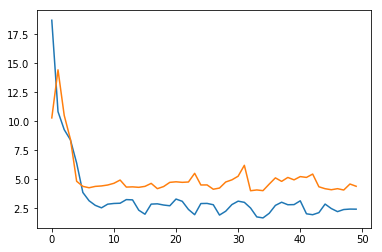

In [34]:
# plot metrics
print(min(history_SimpleModel_1_mirror.history['val_rmse']))
plt.plot(history_SimpleModel_1_mirror.history['rmse'])
plt.plot(history_SimpleModel_1_mirror.history['val_rmse'])
plt.show()

### 2. Test rotating alone

**5 degree**

In [36]:
# transform data
degree = -5
n_point = 8
X_train_model = np.concatenate((X_train_nm, rotate_X(X_train_nm, degree)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, rotate_y(y_train_nm, degree, n_point)), axis=0)
X_val_model = np.concatenate((X_val_nm, rotate_X(X_val_nm, degree)), axis=0).reshape(-1,96,96,1)
y_val_model = np.concatenate((y_val_nm, rotate_y(y_val_nm, degree, n_point)), axis=0)

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(2794, 96, 96, 1)
(2794, 8)


In [ ]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_rotate_5 = model.fit(X_train_model, y_train_model, \
                                        epochs=20, shuffle=True, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

In [ ]:
# plot metrics
print(min(history_SimpleModel_1_rotate_5.history['val_rmse']))
plt.plot(history_SimpleModel_1_rotate_5.history['rmse'])
plt.plot(history_SimpleModel_1_rotate_5.history['val_rmse'])
plt.show()

**10 degree**

In [37]:
# transform data
degree = -10
n_point = 8
X_train_model = np.concatenate((X_train_nm, rotate_X(X_train_nm, degree)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, rotate_y(y_train_nm, degree, n_point)), axis=0)
X_val_model = np.concatenate((X_val_nm, rotate_X(X_val_nm, degree)), axis=0).reshape(-1,96,96,1)
y_val_model = np.concatenate((y_val_nm, rotate_y(y_val_nm, degree, n_point)), axis=0)

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(2794, 96, 96, 1)
(2794, 8)


In [ ]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_rotate_10 = model.fit(X_train_model, y_train_model, \
                                        epochs=20, shuffle=True, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

In [ ]:
# plot metrics
print(min(history_SimpleModel_1_rotate_10.history['val_rmse']))
plt.plot(history_SimpleModel_1_rotate_10.history['rmse'])
plt.plot(history_SimpleModel_1_rotate_10.history['val_rmse'])
plt.show()

**15 degree**

In [38]:
# transform data
degree = -15
n_point = 8
X_train_model = np.concatenate((X_train_nm, rotate_X(X_train_nm, degree)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, rotate_y(y_train_nm, degree, n_point)), axis=0)
X_val_model = np.concatenate((X_val_nm, rotate_X(X_val_nm, degree)), axis=0).reshape(-1,96,96,1)
y_val_model = np.concatenate((y_val_nm, rotate_y(y_val_nm, degree, n_point)), axis=0)

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(2794, 96, 96, 1)
(2794, 8)


In [ ]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_rotate_15 = model.fit(X_train_model, y_train_model, \
                                        epochs=20, shuffle=True, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

In [ ]:
# plot metrics
print(min(history_SimpleModel_1_rotate_15.history['val_rmse']))
plt.plot(history_SimpleModel_1_rotate_15.history['rmse'])
plt.plot(history_SimpleModel_1_rotate_15.history['val_rmse'])
plt.show()

### 3. Test contrast reduction alone

**90 percent**

In [40]:
# transform data
percent = 0.9
X_train_model = np.concatenate((X_train_nm, reduce_contrast(X_train_nm, percent)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, y_train_nm), axis=0)
X_val_model = np.concatenate((X_val_nm, reduce_contrast(X_val_nm, percent)), axis=0).reshape(-1,96,96,1)
y_val_model = np.concatenate((y_val_nm, y_val_nm), axis=0)

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(2794, 96, 96, 1)
(2794, 8)


In [ ]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_contrast_90 = model.fit(X_train_model, y_train_model, \
                                        epochs=20, shuffle=True, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

In [ ]:
# plot metrics
print(min(history_SimpleModel_1_contrast_90.history['val_rmse']))
plt.plot(history_SimpleModel_1_contrast_90.history['rmse'])
plt.plot(history_SimpleModel_1_contrast_90.history['val_rmse'])
plt.show()

**80 percent**

In [41]:
# transform data
percent = 0.8
X_train_model = np.concatenate((X_train_nm, reduce_contrast(X_train_nm, percent)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, y_train_nm), axis=0)
X_val_model = np.concatenate((X_val_nm, reduce_contrast(X_val_nm, percent)), axis=0).reshape(-1,96,96,1)
y_val_model = np.concatenate((y_val_nm, y_val_nm), axis=0)

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(2794, 96, 96, 1)
(2794, 8)


In [ ]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_contrast_80 = model.fit(X_train_model, y_train_model, \
                                        epochs=20, shuffle=True, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

In [ ]:
# plot metrics
print(min(history_SimpleModel_1_contrast_80.history['val_rmse']))
plt.plot(history_SimpleModel_1_contrast_80.history['rmse'])
plt.plot(history_SimpleModel_1_contrast_80.history['val_rmse'])
plt.show()

**70 percent**

In [42]:
# transform data
percent = 0.7
X_train_model = np.concatenate((X_train_nm, reduce_contrast(X_train_nm, percent)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, y_train_nm), axis=0)
X_val_model = np.concatenate((X_val_nm, reduce_contrast(X_val_nm, percent)), axis=0).reshape(-1,96,96,1)
y_val_model = np.concatenate((y_val_nm, y_val_nm), axis=0)

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(2794, 96, 96, 1)
(2794, 8)


In [ ]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_contrast_70 = model.fit(X_train_model, y_train_model, \
                                        epochs=20, shuffle=True, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

In [ ]:
# plot metrics
print(min(history_SimpleModel_1_contrast_70.history['val_rmse']))
plt.plot(history_SimpleModel_1_contrast_70.history['rmse'])
plt.plot(history_SimpleModel_1_contrast_70.history['val_rmse'])
plt.show()

### 4. Test all three transformations combined

In [43]:
# transform data
degree = -5
n_point = 8
percent = 0.9
X_train_model = np.concatenate((X_train_nm, reduce_contrast(rotate_X(mirror_X(X_train_nm), degree), percent)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, rotate_y(mirror_y(y_train_nm, n_point), degree, n_point)), axis=0)
X_val_model = np.concatenate((X_val_nm, reduce_contrast(rotate_X(mirror_X(X_val_nm), degree), percent)), axis=0).reshape(-1,96,96,1)
y_val_model = np.concatenate((y_val_nm, rotate_y(mirror_y(y_val_nm, n_point), degree, n_point)), axis=0)

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(2794, 96, 96, 1)
(2794, 8)


In [ ]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_trans = model.fit(X_train_model, y_train_model, \
                                        epochs=20, shuffle=True, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

In [ ]:
# plot metrics
print(min(history_SimpleModel_1_trans.history['val_rmse']))
plt.plot(history_SimpleModel_1_trans.history['rmse'])
plt.plot(history_SimpleModel_1_trans.history['val_rmse'])
plt.show()

In [520]:
X_train_rotate.max()

343.64848890014355

In [502]:
test = rotate(X_train.reshape(-1,96,96)[3], degree, reshape=False).reshape(96*96)

In [504]:
X_train[3]

array([179., 179., 179., ...,  55.,  57.,  55.])

In [506]:
test.max()

239.34175779242386

In [ ]:
# mirroring
# rotation
# stretching
# shift 
# contrast reduction

In [43]:
~np.isnan(y_train).any(axis=1)[:100]

array([False, False,  True, False, False,  True, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False,  True, False,  True, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True,  True, False,  True, False, False, False,  True,
       False, False, False, False, False,  True,  True, False, False,
        True, False, False, False, False, False,  True,  True,  True,
       False,  True, False,  True,  True, False, False,  True, False,
       False, False,  True, False,  True, False, False,  True,  True,
        True, False,  True, False, False, False, False,  True, False,
       False])